<a href="https://colab.research.google.com/github/aramasethu/CS_573_project/blob/main/VAR_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting google drive

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mobility data

In [3]:
mobility = pd.read_csv (r'/content/drive/MyDrive/CS_573_Group_project/Data/Global_Mobility_Report.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
mobility_country1 = mobility[mobility['sub_region_1'].isna()]
mobility_country = mobility_country1[mobility_country1['metro_area'].isna()]

In [5]:
mobility_country = mobility_country.drop(columns=['country_region_code','sub_region_1', 'sub_region_2','metro_area', 'iso_3166_2_code','census_fips_code','place_id'])

In [6]:
mobility_country['date'] = mobility_country['date'].astype('datetime64[ns]')

In [7]:
mobility_country = mobility_country.rename(columns={ 'country_region': 'country'})

## Vaccination data loading

In [8]:
vec_cases = pd.read_csv(r'/content/drive/MyDrive/CS_573_Group_project/Data/owid-covid-data.csv')

In [9]:
vec_cases_scraped = vec_cases[['location', 'date', 'total_cases', 'total_deaths', 'population',
                              'new_vaccinations_smoothed', 'new_people_vaccinated_smoothed']]

In [10]:
vec_cases_new = vec_cases_scraped.copy()

In [11]:
vec_cases_new['total_cases'] = vec_cases_new['total_cases'].replace(np.nan, 0)
vec_cases_new['total_deaths'] = vec_cases_new['total_deaths'].replace(np.nan, 0)
vec_cases_new['new_vaccinations_smoothed'] = vec_cases_new['new_vaccinations_smoothed'].replace(np.nan, 0)
vec_cases_new['new_people_vaccinated_smoothed'] = vec_cases_new['new_people_vaccinated_smoothed'].replace(np.nan, 0)

In [12]:

vec_cases_new['date'] = pd.to_datetime(vec_cases_new['date']).dt.strftime('%Y/%m/%d')

In [13]:
vec_cases_new = vec_cases_new.rename(columns={'location': 'country'})

In [14]:
vec_cases_new['date'] = vec_cases_new['date'].astype('datetime64[ns]')

## Lockdown data

In [15]:
lockdown = pd.read_excel (r'/content/drive/MyDrive/CS_573_Group_project/Data/OxCGRT_timeseries_all.xlsx')

In [16]:
lockdown_new = lockdown.drop(columns={"country_name","country_code"})
lockdown_new.columns = pd.to_datetime(lockdown_new.columns)

In [17]:
lockdown_input = pd.DataFrame(columns=["country_name","lockdown_index","date"])
for i in range(lockdown_new.shape[1]):
  country = lockdown[{"country_name"}]
  index = lockdown_new.iloc[:,i]
  index_con = pd.concat([country,index], axis=1, ignore_index=True)
  index_con["date"] = index.name
  index_con = index_con.rename(columns={0: 'country_name',  1: 'lockdown_index'})
  lockdown_input = pd.concat([lockdown_input,index_con],ignore_index=True)

In [18]:
lockdown_input = lockdown_input.sort_values('country_name',ascending=True)

In [19]:
lockdown_input = lockdown_input.rename(columns={"country_name":"country"})

## Merge all datasets

In [20]:
df_merged1 = vec_cases_new.merge(mobility_country, on=['country', 'date'])

In [21]:
df_merged1.shape

(97134, 13)

In [22]:
df_merged = df_merged1.merge(lockdown_input, on=['country', 'date'])

In [23]:
df_merged['weekday'] = df_merged['date'].dt.dayofweek

In [24]:
# cases
df_merged = df_merged.sort_values(by=['country', 'date'])
df_merged['new_cases_raw']=df_merged.groupby(['country'])['total_cases'].diff().fillna(0)
df_merged['cases_ppm'] = (df_merged['new_cases_raw'] / df_merged['population'])*1000000

# deaths
df_merged['new_deaths_raw']=df_merged.groupby(['country'])['total_deaths'].diff().fillna(0)
df_merged['deaths_ppm'] = (df_merged['new_deaths_raw'] / df_merged['population'])*1000000

# vaccination cumulative
df_merged['total_vaccinations'] = df_merged.groupby(['country'])['new_people_vaccinated_smoothed'].cumsum()


In [25]:
df_merged = df_merged.dropna()

In [26]:
df_merged_US = df_merged.query("country == 'United States'")

In [27]:
df_merged_US.head()

,country,date,total_cases,total_deaths,population,new_vaccinations_smoothed,new_people_vaccinated_smoothed,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lockdown_index,weekday,new_cases_raw,cases_ppm,new_deaths_raw,deaths_ppm,total_vaccinations
87540,United States,2020-02-15,14.0,0.0,332915074.0,0.0,0.0,6.0,2.0,15.0,3.0,2.0,-1.0,5.56,5,0.0,0.0,0.0,0.0,0.0
87541,United States,2020-02-16,14.0,0.0,332915074.0,0.0,0.0,7.0,1.0,16.0,2.0,0.0,-1.0,5.56,6,0.0,0.0,0.0,0.0,0.0
87542,United States,2020-02-17,14.0,0.0,332915074.0,0.0,0.0,6.0,0.0,28.0,-9.0,-24.0,5.0,5.56,0,0.0,0.0,0.0,0.0,0.0
87543,United States,2020-02-18,14.0,0.0,332915074.0,0.0,0.0,0.0,-1.0,6.0,1.0,0.0,1.0,5.56,1,0.0,0.0,0.0,0.0,0.0
87544,United States,2020-02-19,14.0,0.0,332915074.0,0.0,0.0,2.0,0.0,8.0,1.0,1.0,0.0,5.56,2,0.0,0.0,0.0,0.0,0.0


### Lag model

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels as sm

In [ ]:
sm.__version__

'0.10.2'

In [ ]:
df_merged_US.dtypes

country                                                       object
date                                                  datetime64[ns]
total_cases                                                  float64
total_deaths                                                 float64
population                                                   float64
new_vaccinations_smoothed                                    float64
new_people_vaccinated_smoothed                               float64
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
lockdown_index                                               float64
weekday                           

In [ ]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['total_cases', 'workplaces_percent_change_from_baseline']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.0999 , p=0.0001  , df_denom=761, df_num=1
ssr based chi2 test:   chi2=16.1634 , p=0.0001  , df=1
likelihood ratio test: chi2=15.9948 , p=0.0001  , df=1
parameter F test:         F=16.0999 , p=0.0001  , df_denom=761, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1207  , p=0.8864  , df_denom=758, df_num=2
ssr based chi2 test:   chi2=0.2429  , p=0.8856  , df=2
likelihood ratio test: chi2=0.2429  , p=0.8856  , df=2
parameter F test:         F=0.1207  , p=0.8864  , df_denom=758, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2027  , p=0.0058  , df_denom=755, df_num=3
ssr based chi2 test:   chi2=12.7250 , p=0.0053  , df=3
likelihood ratio test: chi2=12.6199 , p=0.0055  , df=3
parameter F test:         F=4.2027  , p=0.0058  , df_denom=755, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3513  , p=0.2493  

In [ ]:
df_sub = df_merged_US[['deaths_ppm', 'cases_ppm', 'total_vaccinations', 'workplaces_percent_change_from_baseline', \
                       'residential_percent_change_from_baseline', 'lockdown_index', 'date']]

In [ ]:
from sklearn.preprocessing import StandardScaler
trans = StandardScaler()
data = trans.fit_transform(df_sub)
dataset = pd.DataFrame(data)

In [ ]:
dataset.head()

,0,1,2,3,4,5
0,-1.276811,-0.708702,-0.977277,2.173862,-1.747345,-4.255712
1,-1.276811,-0.708702,-0.977277,2.023607,-1.747345,-4.255712
2,-1.276811,-0.708702,-0.977277,0.220545,-0.536665,-4.255712
3,-1.276811,-0.708702,-0.977277,2.023607,-1.343785,-4.255712
4,-1.276811,-0.708702,-0.977277,2.098734,-1.545565,-4.255712


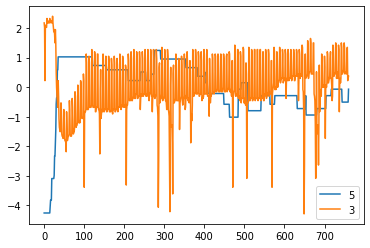

In [ ]:
series = dataset[[5, 3]]
series.plot()


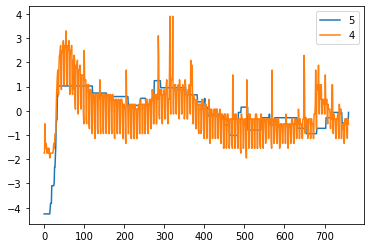

In [ ]:
series = dataset[[5, 4]]
series.plot()


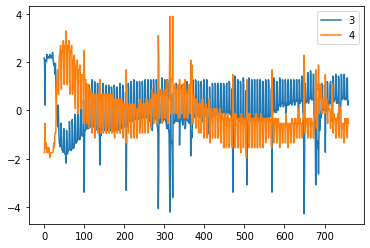

In [ ]:
series = dataset[[3, 4]]
series.plot()

In [ ]:
df_sub['mov_avg'] = df_sub['cases_ppm'].rolling(7).sum()
df_sub['mov_avg_work_mob'] = df_sub['workplaces_percent_change_from_baseline'].rolling(7).sum()
df_sub['mov_avg_res_mob'] = df_sub['residential_percent_change_from_baseline'].rolling(7).sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

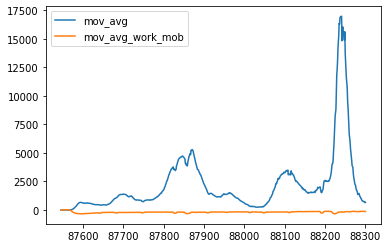

In [ ]:
series = df_sub[['mov_avg', 'lockdown_index']]
series.plot()

Text(0, 0.5, 'mov_avg_work_mob')

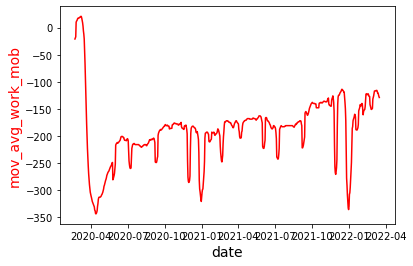

In [ ]:
series = df_sub[['mov_avg_work_mob', 'lockdown_index', 'date']]
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(df_sub.date, df_sub.mov_avg_work_mob, color="red")
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label
ax.set_ylabel("mov_avg_work_mob",color="red",fontsize=14)

In [ ]:
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.lockdown_index,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [ ]:
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.lockdown_index,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.mov_avg,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('cases_vs_workplace_mob.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

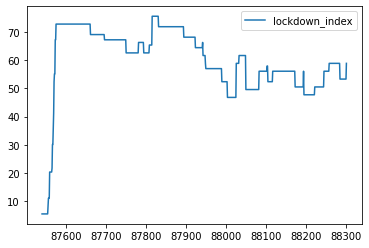

In [ ]:
series = df_sub[['lockdown_index']]
series.plot()

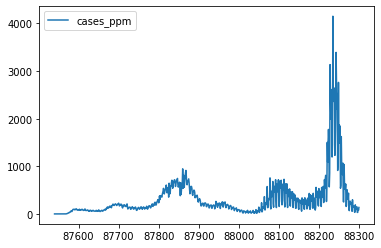

In [ ]:
series = df_sub[['cases_ppm']]
series.plot()

In [ ]:
df_sub

,deaths_ppm,cases_ppm,total_vaccinations,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lockdown_index,mov_avg
87540,0.000000,0.000000,0.0,2.0,-1.0,5.56,NaN
87541,0.000000,0.000000,0.0,0.0,-1.0,5.56,NaN
87542,0.000000,0.000000,0.0,-24.0,5.0,5.56,NaN
87543,0.000000,0.000000,0.0,0.0,1.0,5.56,NaN
87544,0.000000,0.000000,0.0,1.0,0.0,5.56,NaN
...,...,...,...,...,...,...,...
88296,1.279606,31.428436,254619167.0,-10.0,4.0,53.24,745.682666
88297,0.504633,32.518804,254667021.0,-9.0,2.0,53.24,745.030848
88298,-7.854856,104.362952,254713948.0,-24.0,6.0,53.24,658.897770
88299,3.847828,76.746300,254760201.0,-23.0,5.0,53.24,646.245895


In [ ]:
series = dataset[[]]
series.plot()



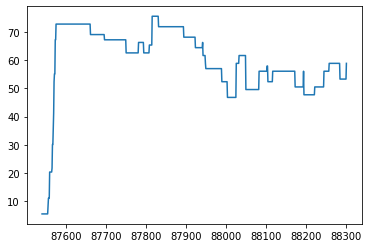

In [ ]:
series = df_merged_US['lockdown_index']
series.plot()


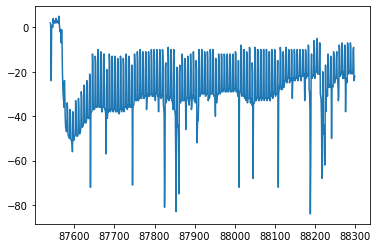

In [ ]:
series = df_merged_US['workplaces_percent_change_from_baseline']
series.plot()

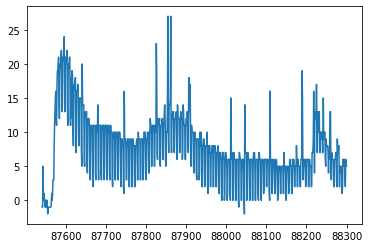

In [ ]:
series = df_merged_US['residential_percent_change_from_baseline']
series.plot()

In [ ]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['residential_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7872  , p=0.0031  , df_denom=757, df_num=1
ssr based chi2 test:   chi2=8.8220  , p=0.0030  , df=1
likelihood ratio test: chi2=8.7712  , p=0.0031  , df=1
parameter F test:         F=8.7872  , p=0.0031  , df_denom=757, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=34.5154 , p=0.0000  , df_denom=754, df_num=2
ssr based chi2 test:   chi2=69.4886 , p=0.0000  , df=2
likelihood ratio test: chi2=66.4894 , p=0.0000  , df=2
parameter F test:         F=34.5154 , p=0.0000  , df_denom=754, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.7235  , p=0.0000  , df_denom=751, df_num=3
ssr based chi2 test:   chi2=26.4144 , p=0.0000  , df=3
likelihood ratio test: chi2=25.9646 , p=0.0000  , df=3
parameter F test:         F=8.7235  , p=0.0000  , df_denom=751, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.7458 , p=0.0000  

In [ ]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['residential_percent_change_from_baseline', 'total_vaccinations']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.7722 , p=0.0000  , df_denom=757, df_num=1
ssr based chi2 test:   chi2=25.8743 , p=0.0000  , df=1
likelihood ratio test: chi2=25.4436 , p=0.0000  , df=1
parameter F test:         F=25.7722 , p=0.0000  , df_denom=757, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.0299 , p=0.0000  , df_denom=754, df_num=2
ssr based chi2 test:   chi2=30.2592 , p=0.0000  , df=2
likelihood ratio test: chi2=29.6716 , p=0.0000  , df=2
parameter F test:         F=15.0299 , p=0.0000  , df_denom=754, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4891  , p=0.0010  , df_denom=751, df_num=3
ssr based chi2 test:   chi2=16.6209 , p=0.0008  , df=3
likelihood ratio test: chi2=16.4413 , p=0.0009  , df=3
parameter F test:         F=5.4891  , p=0.0010  , df_denom=751, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6416  , p=0.0010  

In [ ]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['residential_percent_change_from_baseline', 'lockdown_index']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=63.6646 , p=0.0000  , df_denom=757, df_num=1
ssr based chi2 test:   chi2=63.9169 , p=0.0000  , df=1
likelihood ratio test: chi2=61.3709 , p=0.0000  , df=1
parameter F test:         F=63.6646 , p=0.0000  , df_denom=757, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=39.1457 , p=0.0000  , df_denom=754, df_num=2
ssr based chi2 test:   chi2=78.8106 , p=0.0000  , df=2
likelihood ratio test: chi2=74.9818 , p=0.0000  , df=2
parameter F test:         F=39.1457 , p=0.0000  , df_denom=754, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.9868 , p=0.0000  , df_denom=751, df_num=3
ssr based chi2 test:   chi2=45.3794 , p=0.0000  , df=3
likelihood ratio test: chi2=44.0729 , p=0.0000  , df=3
parameter F test:         F=14.9868 , p=0.0000  , df_denom=751, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=11.5713 , p=0.0000  

In [ ]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['residential_percent_change_from_baseline', 'deaths_ppm']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0689  , p=0.7930  , df_denom=757, df_num=1
ssr based chi2 test:   chi2=0.0692  , p=0.7925  , df=1
likelihood ratio test: chi2=0.0692  , p=0.7925  , df=1
parameter F test:         F=0.0689  , p=0.7930  , df_denom=757, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3161  , p=0.7291  , df_denom=754, df_num=2
ssr based chi2 test:   chi2=0.6364  , p=0.7275  , df=2
likelihood ratio test: chi2=0.6361  , p=0.7276  , df=2
parameter F test:         F=0.3161  , p=0.7291  , df_denom=754, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5544  , p=0.0141  , df_denom=751, df_num=3
ssr based chi2 test:   chi2=10.7626 , p=0.0131  , df=3
likelihood ratio test: chi2=10.6869 , p=0.0135  , df=3
parameter F test:         F=3.5544  , p=0.0141  , df_denom=751, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0480  , p=0.0166  

In [ ]:
df_merged_US.dtypes

country                                                       object
date                                                  datetime64[ns]
total_cases                                                  float64
total_deaths                                                 float64
population                                                   float64
new_vaccinations_smoothed                                    float64
new_people_vaccinated_smoothed                               float64
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
lockdown_index                                               float64
weekday                           

### test-train-validation split


In [ ]:
from sklearn.model_selection import train_test_split
def train_test_split_udf (df, frac):
    X_train, X_test = train_test_split(df, test_size=(frac), random_state=22)
    return X_train, X_test

In [ ]:
df_train_1, df_test_1 = train_test_split_udf (df_merged, 0.2)
df_train_2, df_val_1 = train_test_split_udf (df_train_1, 0.125)

## Stationarity

In [ ]:
df_sub.tail(5)

,deaths_ppm,cases_ppm,total_vaccinations,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lockdown_index,date,mov_avg,mov_avg_work_mob,mov_avg_res_mob
88296,1.279606,31.428436,254619167.0,-10.0,4.0,53.24,2022-03-12,745.682666,-121.0,34.0
88297,0.504633,32.518804,254667021.0,-9.0,2.0,53.24,2022-03-13,745.030848,-121.0,34.0
88298,-7.854856,104.362952,254713948.0,-24.0,6.0,53.24,2022-03-14,658.897770,-124.0,34.0
88299,3.847828,76.746300,254760201.0,-23.0,5.0,53.24,2022-03-15,646.245895,-127.0,34.0
88300,5.836323,135.214664,254805930.0,-22.0,5.0,58.80,2022-03-16,669.209710,-129.0,33.0


In [ ]:
train = df_sub[df_sub['date'] < pd.to_datetime("2021-12", format='%Y-%m')]
train['train'] = train['mov_avg_work_mob']
del train['date']
del train['mov_avg_work_mob']
test = df_sub[df_sub['date'] >= pd.to_datetime("2021-12", format='%Y-%m')]
del test['date']
test['test'] = test['mov_avg_work_mob']
del test['mov_avg_work_mob']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
test.shape

(106, 9)

In [ ]:
train.shape

(655, 9)

In [ ]:
df_sub.shape

(761, 10)

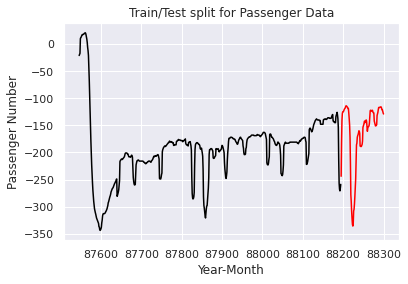

In [ ]:
import seaborn as sns
plt.plot(train['train'], color = "black")
plt.plot(test['test'], color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

Text(0, 0.5, 'mov_avg_work_mob')

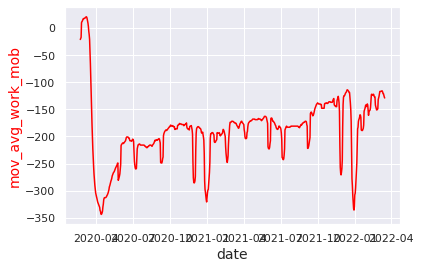

In [ ]:
series = df_sub[['mov_avg_work_mob', 'lockdown_index', 'date']]
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(df_sub.date, df_sub.mov_avg_work_mob, color="red")
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label
ax.set_ylabel("mov_avg_work_mob",color="red",fontsize=14)

In [ ]:
import seaborn as sns
plt.plot(train['mov_'], color = "black")
plt.plot(test['test'], color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 8.1 MB/s 
     |████████████████████████████████| 9.8 MB 37.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
train = train.dropna()

In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(train['train'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train['train'])
forecast = model.predict(n_periods=len(test['test']))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4407.907, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4627.838, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4414.792, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4475.521, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4627.026, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4412.762, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4412.783, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4369.848, Time=1.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4414.204, Time=0.50 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4397.024, Time=2.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4397.023, Time=1.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4379.117, Time=1.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4409.521, Time=0.88 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(3,1,2)(0,0,0)[0]             : 

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test['test'],forecast))
print("RMSE: ", rms)

RMSE:  77.38313099198253


In [ ]:
forecast.head()

,Prediction
88195,-243.563356
88196,-222.887709
88197,-206.656458
88198,-201.506395
88199,-206.674176


In [ ]:
test[['test']].head()

,test
88195,-244.0
88196,-182.0
88197,-141.0
88198,-128.0
88199,-125.0


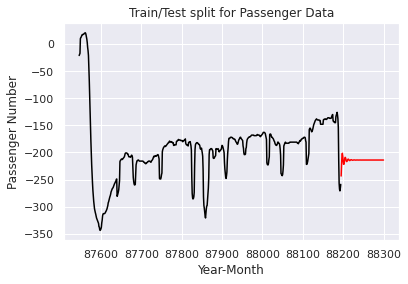

In [ ]:
import seaborn as sns
plt.plot(train['train'], color = "black")
plt.plot(forecast, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

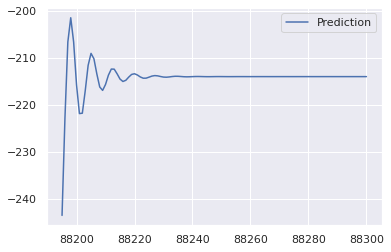

In [ ]:
forecast.plot()

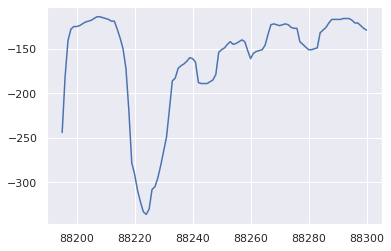

In [ ]:
test['test'].plot()

In [ ]:
test = test.join(forecast)

In [ ]:
test.head()

,deaths_ppm,cases_ppm,total_vaccinations,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lockdown_index,mov_avg,mov_avg_res_mob,test,Prediction
88195,6.178753,412.090082,232844059.0,-22.0,5.0,47.69,1811.323809,58.0,-244.0,-243.563356
88196,11.744737,417.262572,233178650.0,-22.0,6.0,47.69,2108.874169,45.0,-182.0,-222.887709
88197,4.730936,476.662105,233538248.0,-21.0,5.0,47.69,2425.681692,35.0,-141.0,-206.656458
88198,2.012525,200.138129,233909396.0,-6.0,2.0,47.69,2545.622191,33.0,-128.0,-201.506395
88199,1.162459,165.907177,234283882.0,-9.0,3.0,47.69,2581.760536,33.0,-125.0,-206.674176


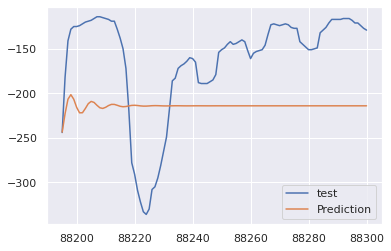

In [ ]:
s = test[['test', 'Prediction']]
s.plot()

In [ ]:
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.lockdown_index,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.mov_avg,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('cases_vs_workplace_mob.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

## Time series

In [33]:
df_merged_US = df_merged_US[['date','retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline'\
                             ,'parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline',\
                             'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline','lockdown_index',\
                             'cases_ppm','deaths_ppm','total_vaccinations']]

df_merged_US = df_merged_US.set_index('date')

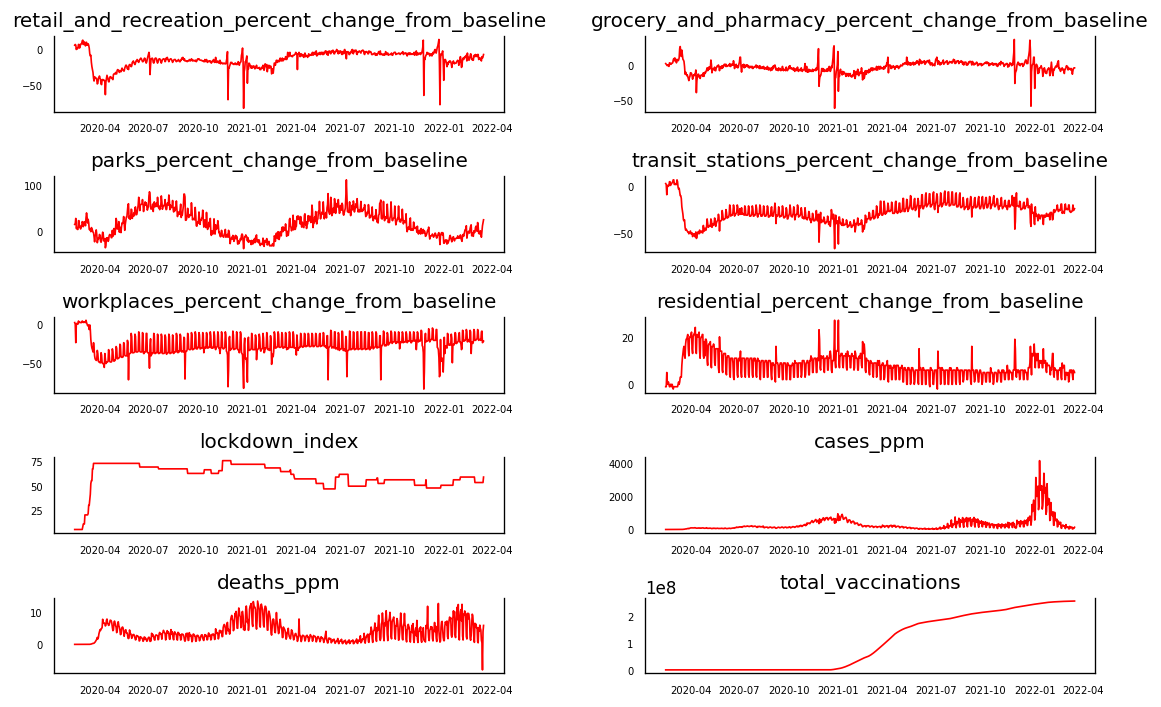

In [40]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
 data = df_merged_US[df_merged_US.columns[i]]
 ax.plot(data, color='red', linewidth=1)
 ax.set_title(df_merged_US.columns[i])
 ax.xaxis.set_ticks_position('none')
 ax.yaxis.set_ticks_position('none')
 ax.spines["top"].set_alpha(0)
 ax.tick_params(labelsize=6)
plt.tight_layout();


In [43]:
from scipy import stats

In [44]:
stat,p = stats.normaltest(df_merged_US.workplaces_percent_change_from_baseline)
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
  print('Data looks Gaussian (fail to reject null hypothesis)')
else:
  print('Data looks non-Gaussian (reject null hypothesis')


Statistics = 44.227, p=0.000
Data looks non-Gaussian (reject null hypothesis


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


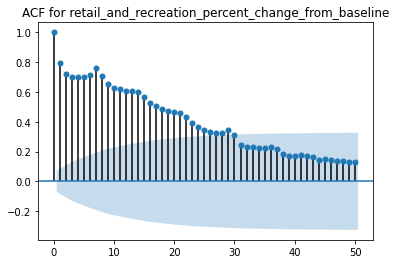

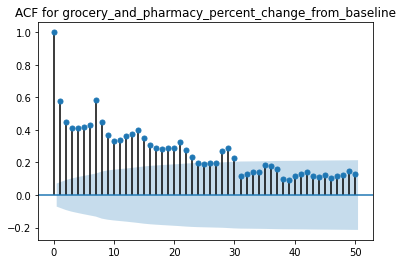

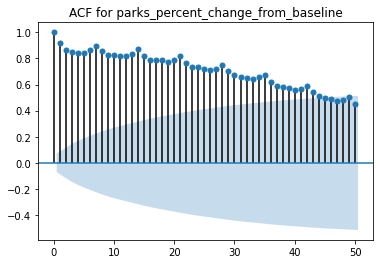

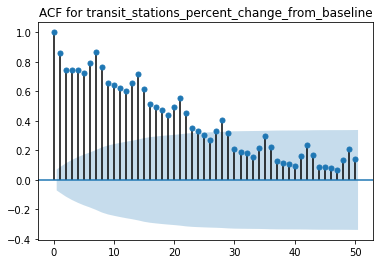

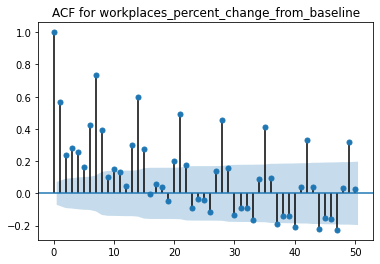

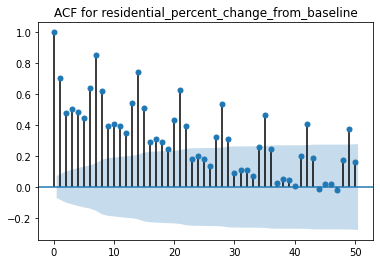

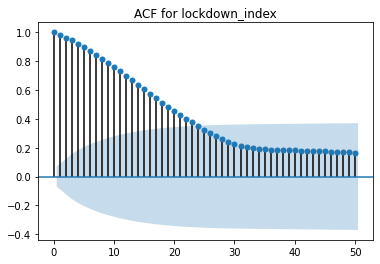

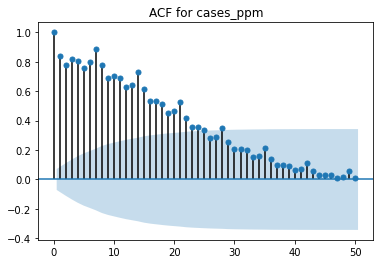

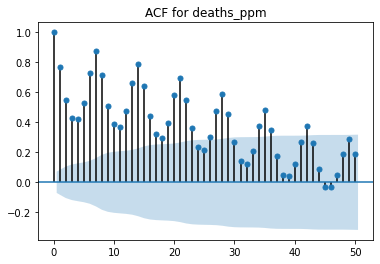

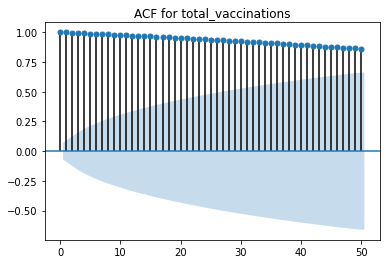

In [46]:
 import statsmodels.api as sm
# plots the autocorrelation plots for each stock's price at 50 lags
for i in df_merged_US:
  sm.graphics.tsa.plot_acf(df_merged_US[i], lags = 50)
  'ACF for %s' % i
  asm.tsa.acf(i, alpha=0.05)
  pacf, ci = sm.tsa.pacf(endog, alpha=0.05)
  plt.show()

In [48]:
import statsmodels.api as sm
# plots the autocorrelation plots for each stock's price at 50 lags
for i in df_merged_US:
   import statsmodels.api as sm
# plots the autocorrelation plots for each stock's price at 50 lags
for i in df_merged_US:

" ACF ", sm.tsa.acf(df_merged_US[i], alpha=0.05
"PACF" , sm.tsa.pacf(df_merged_US[i], alpha=0.05

IndentationError: ignored

In [85]:
n_obs=685
X_train, X_test = df_merged_US[0:-n_obs], df_merged_US[-n_obs:]
print(X_train.shape, X_test.shape)


(76, 10) (685, 10)


In [86]:
X_train_transformed = X_train.diff().dropna()

In [59]:
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_statistics(time_series):
  result = adfuller(time_series.values)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

for i in X_train_transformed:
  augmented_dickey_fuller_statistics(X_train_transformed[i])
  print('Augmented Dickey-Fuller Test:')


ADF Statistic: -1.815249
p-value: 0.372918
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590
Augmented Dickey-Fuller Test:
ADF Statistic: -11.088078
p-value: 0.000000
Critical Values:
	1%: -3.522
	5%: -2.901
	10%: -2.588
Augmented Dickey-Fuller Test:
ADF Statistic: -8.934115
p-value: 0.000000
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Augmented Dickey-Fuller Test:
ADF Statistic: -1.458547
p-value: 0.553909
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590
Augmented Dickey-Fuller Test:
ADF Statistic: -2.354361
p-value: 0.155034
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
Augmented Dickey-Fuller Test:
ADF Statistic: -1.537066
p-value: 0.515102
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591
Augmented Dickey-Fuller Test:
ADF Statistic: -2.541306
p-value: 0.105745
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590
Augmented Dickey-Fuller Test:
ADF Statistic: -2.203634
p-value: 0.204929
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592
Augmented Dic

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


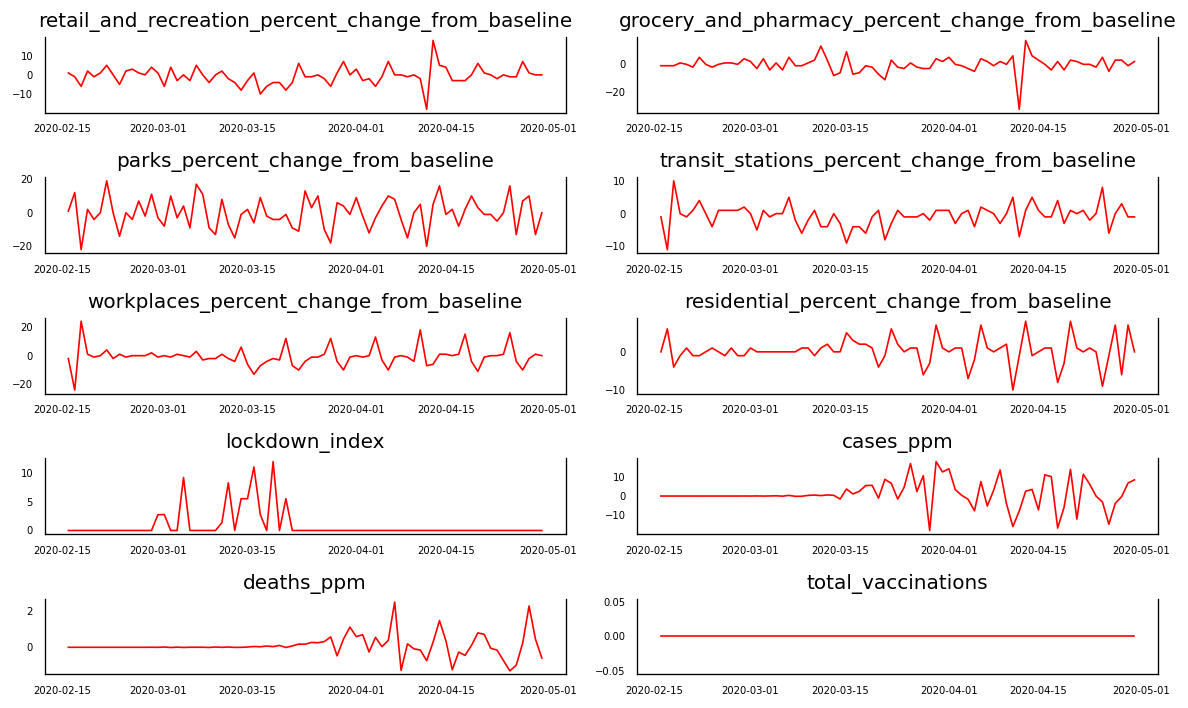

In [62]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
  d = X_train_transformed[X_train_transformed.columns[i]]
  ax.plot(d, color='red', linewidth=1)
  # Decorations
  ax.set_title(X_train_transformed.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines['top'].set_alpha(0)
  ax.tick_params(labelsize=6)
  plt.tight_layout();

In [64]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
      dataset.columns = [var + '_x' for var in variables]
      dataset.index = [var + '_y' for var in variables]
      return dataset
grangers_causality_matrix(df_merged_US, variables = df_merged_US.columns)

,retail_and_recreation_percent_change_from_baseline_x,grocery_and_pharmacy_percent_change_from_baseline_x,parks_percent_change_from_baseline_x,transit_stations_percent_change_from_baseline_x,workplaces_percent_change_from_baseline_x,residential_percent_change_from_baseline_x,lockdown_index_x,cases_ppm_x,deaths_ppm_x,total_vaccinations_x
retail_and_recreation_percent_change_from_baseline_y,0.8487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
grocery_and_pharmacy_percent_change_from_baseline_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
parks_percent_change_from_baseline_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
transit_stations_percent_change_from_baseline_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
workplaces_percent_change_from_baseline_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
residential_percent_change_from_baseline_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lockdown_index_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cases_ppm_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
deaths_ppm_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total_vaccinations_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
X_train_transformed = X_train_transformed[['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline'\
                             ,'parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline',\
                             'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline','lockdown_index',\
                             'cases_ppm','deaths_ppm']]


In [93]:
X_test = X_test[['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline'\
                             ,'parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline',\
                             'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline','lockdown_index',\
                             'cases_ppm','deaths_ppm']]

In [88]:
import statsmodels as smt
from statsmodels.tsa.api import VAR
mod = VAR(X_train_transformed)
res = mod.fit(maxlags=1, ic='aic')
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 25, Apr, 2022
Time:                     02:04:34
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    21.7700
Nobs:                     74.0000    HQIC:                   20.0856
Log likelihood:          -1556.82    FPE:                1.75419e+08
AIC:                      18.9677    Det(Omega_mle):     5.60593e+07
--------------------------------------------------------------------
Results for equation retail_and_recreation_percent_change_from_baseline
                                                           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------
const                                                        -0.184568         0.465041          

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


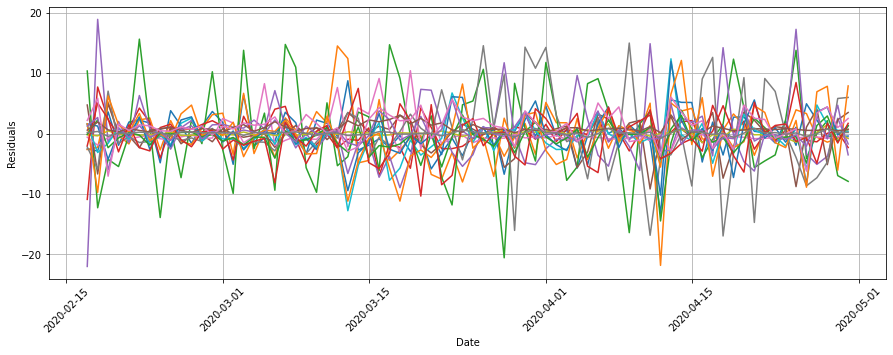

In [90]:
y_fitted = res.fittedvalues
residuals = res.resid
plt.figure(figsize = (15,5))
plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='VAR prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.grid(True)

In [91]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(res.resid)
for col, val in zip(X_train_transformed.columns, out):
  print ((col),':',round(val,2))

retail_and_recreation_percent_change_from_baseline : 2.32
grocery_and_pharmacy_percent_change_from_baseline : 2.02
parks_percent_change_from_baseline : 2.07
transit_stations_percent_change_from_baseline : 1.99
workplaces_percent_change_from_baseline : 2.1
residential_percent_change_from_baseline : 2.21
lockdown_index : 2.2
cases_ppm : 2.1
deaths_ppm : 1.73


In [94]:
# Get the lag order
lag_order = res.k_ar
print(lag_order)
# Input data for forecasting
input_data = X_train_transformed.values[-lag_order:]
print(input_data)
# forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)




1
[[ 0.          2.          0.         -1.          0.          0.
   0.          8.51868906 -0.59775004]]
            retail_and_recreation_percent_change_from_baseline_pred  \
date                                                                  
2020-05-01                                          -2.605762         
2020-05-02                                          -0.733100         
2020-05-03                                          -0.002070         
2020-05-04                                          -0.586788         
2020-05-05                                          -0.767311         
...                                                       ...         
2022-03-12                                          -0.603164         
2022-03-13                                          -0.603164         
2022-03-14                                          -0.603164         
2022-03-15                                          -0.603164         
2022-03-16                              

In [127]:
output = []


In [123]:
df_merged_US.head()

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lockdown_index,cases_ppm,deaths_ppm,total_vaccinations
date,,,,,,,,,,
2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0,5.56,0.0,0.0,0.0
2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0,5.56,0.0,0.0,0.0
2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0,5.56,0.0,0.0,0.0
2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0,5.56,0.0,0.0,0.0
2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0,5.56,0.0,0.0,0.0


In [125]:
# inverting transformation
def invert_transformation(X_train, pred):
  forecast = pred.copy()
  columns = X_train.columns
  for col in columns:
    forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(X_train, pred)
#combining predicted and real data set



In [126]:
output.head()

,retail_and_recreation_percent_change_from_baseline_pred,grocery_and_pharmacy_percent_change_from_baseline_pred,parks_percent_change_from_baseline_pred,transit_stations_percent_change_from_baseline_pred,workplaces_percent_change_from_baseline_pred,residential_percent_change_from_baseline_pred,lockdown_index_pred,cases_ppm_pred,deaths_ppm_pred
date,,,,,,,,,
2020-05-01,-36.605762,-1.509738,-3.712052,-1.033163,1.361464,-0.704197,0.651966,-1.014711,-0.018799
2020-05-02,-37.338862,-1.035488,-0.802271,-0.885738,-0.530161,0.033684,0.975852,0.617318,-0.080020
2020-05-03,-37.340932,0.305394,0.227361,-0.723074,-1.269569,0.498050,0.906071,1.326788,0.088469
2020-05-04,-37.927720,0.013290,-0.233648,-0.542636,-0.556581,0.309701,0.875410,1.280690,0.120960
2020-05-05,-38.695032,-0.309804,-0.521126,-0.666203,-0.362206,0.135636,0.918086,1.071535,0.083307


In [121]:
combine = pd.concat([output['workplaces_percent_change_from_baseline_pred'], X_test['workplaces_percent_change_from_baseline']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.workplaces_percent_change_from_baseline_pred /row.workplaces_percent_change_from_baseline *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='date', ascending=False)

In [122]:
combine.head()

,date,workplaces_percent_change_from_baseline_pred,workplaces_percent_change_from_baseline,accuracy
684,2022-03-16,-0.61,-22.0,2.75%
683,2022-03-15,-0.61,-23.0,2.63%
682,2022-03-14,-0.61,-24.0,2.52%
681,2022-03-13,-0.61,-9.0,6.73%
680,2022-03-12,-0.61,-10.0,6.06%
